<a href="https://colab.research.google.com/github/DevanshBattu/Google-App_Rating/blob/main/Google_playstore_app_rating_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devanshbattu","key":"c45457e618e946936965b38f9188e9bc"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset       Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           3335        144  1.0              
nelgiriyewithana/countries-of-the-world-2023                   Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           2278         85  1.0              
arnavsmayan/netflix-userbase-dataset                           Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           3431         74  1.0              
iamsouravbanerjee/data-science-salaries-2023                   Latest Data Scien

In [5]:
!kaggle datasets download -d lava18/google-play-store-apps

  0% 0.00/1.94M [00:00<?, ?B/s]
100% 1.94M/1.94M [00:00<00:00, 88.6MB/s]


In [6]:
! unzip google-play-store-apps.zip

Archive:  google-play-store-apps.zip
  inflating: googleplaystore.csv     
  inflating: googleplaystore_user_reviews.csv  
  inflating: license.txt             


In [7]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


#**Imports:**

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

#**Load** **Data:**

In [13]:
app_rate = pd.read_csv('googleplaystore.csv')

In [14]:
app_rate = pd.read_csv('googleplaystore.csv')
app_rate.rename(columns={_col: _col.lower().replace(' ', '_') for _col in app_rate.columns}, inplace=True)
app_rate.dropna(inplace = True)
for _cat_col in ['type', 'content_rating', 'genres', 'category', 'app', 'current_ver', 'android_ver']:
    app_rate[_cat_col] = app_rate[_cat_col].str.lower()
app_rate.drop_duplicates(subset=['app'], inplace=True)

In [15]:
app_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8174 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   app             8174 non-null   object 
 1   category        8174 non-null   object 
 2   rating          8174 non-null   float64
 3   reviews         8174 non-null   object 
 4   size            8174 non-null   object 
 5   installs        8174 non-null   object 
 6   type            8174 non-null   object 
 7   price           8174 non-null   object 
 8   content_rating  8174 non-null   object 
 9   genres          8174 non-null   object 
 10  last_updated    8174 non-null   object 
 11  current_ver     8174 non-null   object 
 12  android_ver     8174 non-null   object 
dtypes: float64(1), object(12)
memory usage: 894.0+ KB


#**Feature** Engineering

In [16]:
target_encoder = TargetEncoder(cols=['android_ver'])
app_rate['android_encoded'] = target_encoder.fit_transform(app_rate['android_ver'], app_rate['rating'])
target_encoder = TargetEncoder(cols=['current_ver'])
app_rate['current_encoded'] = target_encoder.fit_transform(app_rate['current_ver'], app_rate['rating'])


app_rate['reviews'] = app_rate['reviews'].astype(str).astype(int)
app_rate['price'] = app_rate['price'].str.replace('$', '')
app_rate['price'] = app_rate['price'].astype(str).astype(float)
app_rate['size'] = app_rate['size'].str.replace('M', '').str.replace('k', '').str.replace('Varies with device', '0').astype(str).astype(float)
app_rate['installs'] = app_rate['installs'].str.replace('+', '')
app_rate['installs'] = app_rate['installs'].str.replace(',', '')
app_rate['installs'] = app_rate['installs'].astype(str).astype(float)


content_rating = pd.get_dummies( app_rate['content_rating'],drop_first=True)
paid = pd.get_dummies( app_rate['type'],drop_first=True)
rating = pd.concat([app_rate, content_rating, paid], axis = 1)


category_freq_map = rating['category'].value_counts().to_dict()
rating['category'] = rating['category'].map(category_freq_map)
rating['reviews_to_installs_ratio'] = rating['reviews'] / rating['installs']
rating['app_name_length'] = rating['app'].apply(len)


rating['last_updated'] = pd.to_datetime(rating['last_updated'])
rating['year_upd'] = rating['last_updated'].dt.year
rating['month_upd'] = rating['last_updated'].dt.month
rating['day_of_year'] = rating['last_updated'].dt.day_of_year
rating['day'] = rating['last_updated'].dt.day
rating['day_of_week'] = rating['last_updated'].dt.day_of_week

le = LabelEncoder()
rating['app'] = le.fit_transform(rating['app'])
rating['genre_le'] = le.fit_transform(rating['genres'])


top_20 = [x for x in rating['genres'].value_counts().sort_values(ascending = False).head(20).index ]
for l in top_20:
  rating[l] = np.where(rating['genres'] == l, 1, 0)


<ipython-input-16-059fe5e36433>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app_rate['price'] = app_rate['price'].str.replace('$', '')
<ipython-input-16-059fe5e36433>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  app_rate['installs'] = app_rate['installs'].str.replace('+', '')


In [17]:
rating_top = rating.drop(['type','content_rating','current_ver','android_ver','genres','unrated','last_updated'], axis =1)

In [18]:
app_rate.to_csv('rating_top.csv', index=False)

#**Data Visualization:**

<Axes: xlabel='rating', ylabel='Count'>

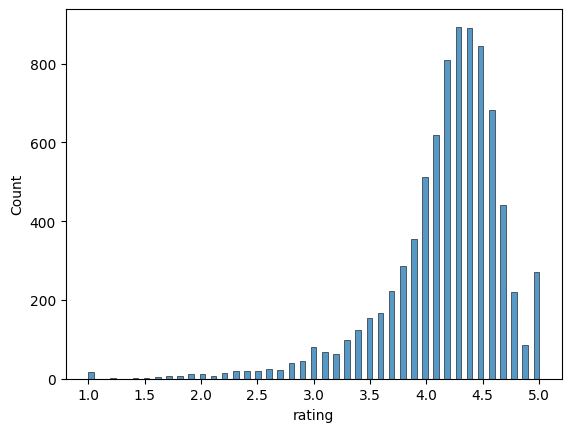

In [19]:
sns.histplot(rating['rating'])

In [20]:
rating.corr()

<ipython-input-20-cc9eb25757df>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rating.corr()


,app,category,rating,reviews,size,installs,price,android_encoded,current_encoded,everyone,...,business,photography,communication,health & fitness,news & magazines,social,simulation,travel & local,shopping,arcade
app,1.000000,-0.036991,0.039199,0.028472,-0.016966,0.040806,0.012539,0.048429,0.067805,-0.044640,...,-0.012135,0.001908,0.001801,0.015390,-0.015844,0.038617,0.003637,0.013384,0.009013,0.028157
category,-0.036991,1.000000,0.003731,-0.007744,0.036966,-0.035716,0.003639,-0.072031,-0.062865,-0.107043,...,-0.114766,-0.114870,-0.115363,-0.116443,-0.117778,-0.117764,0.266404,-0.117053,-0.117017,0.079859
rating,0.039199,0.003731,1.000000,0.054879,-0.030400,0.039904,-0.020368,0.144759,0.444913,-0.025863,...,-0.025319,-0.004395,-0.017564,0.023679,-0.015603,0.021690,-0.009484,-0.029728,0.015685,0.028173
reviews,0.028472,-0.007744,0.054879,1.000000,-0.009915,0.623895,-0.007578,0.074449,0.094282,-0.060646,...,-0.019921,0.013529,0.077910,-0.014745,-0.011426,0.069925,-0.008999,-0.008532,-0.000589,0.031469
size,-0.016966,0.036966,-0.030400,-0.009915,1.000000,-0.025365,0.024995,-0.141544,-0.058733,0.010284,...,-0.019379,-0.037305,0.031854,-0.019032,-0.037262,-0.024961,0.017448,-0.022234,-0.004142,0.006358
installs,0.040806,-0.035716,0.039904,0.623895,-0.025365,1.000000,-0.009411,0.091112,0.112825,-0.044991,...,-0.020330,0.026780,0.104659,-0.013416,0.006689,0.049113,-0.015242,0.016715,-0.003591,0.032272
price,0.012539,0.003639,-0.020368,-0.007578,0.024995,-0.009411,1.000000,-0.009999,-0.033991,0.012358,...,-0.008082,-0.007705,-0.008265,-0.008569,-0.009410,-0.009461,-0.006747,-0.007207,-0.008721,-0.006198
android_encoded,0.048429,-0.072031,0.144759,0.074449,-0.141544,0.091112,-0.009999,1.000000,0.212267,-0.033544,...,-0.005849,-0.009018,-0.000946,0.029439,0.054617,0.029410,-0.010845,0.019789,0.036119,0.006310
current_encoded,0.067805,-0.062865,0.444913,0.094282,-0.058733,0.112825,-0.033991,0.212267,1.000000,-0.045359,...,-0.011621,0.017729,0.026194,0.039750,0.029028,0.047302,-0.021657,0.000206,0.035927,0.005798
everyone,-0.044640,-0.107043,-0.025863,-0.060646,0.010284,-0.044991,0.012358,-0.033544,-0.045359,1.000000,...,0.081967,0.065912,0.041679,0.038164,-0.080707,-0.185687,-0.047474,0.062165,0.012143,-0.037318


<ipython-input-21-3554e10d5fc4>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(rating.corr(), cmap = 'coolwarm', annot = True)


<Axes: >

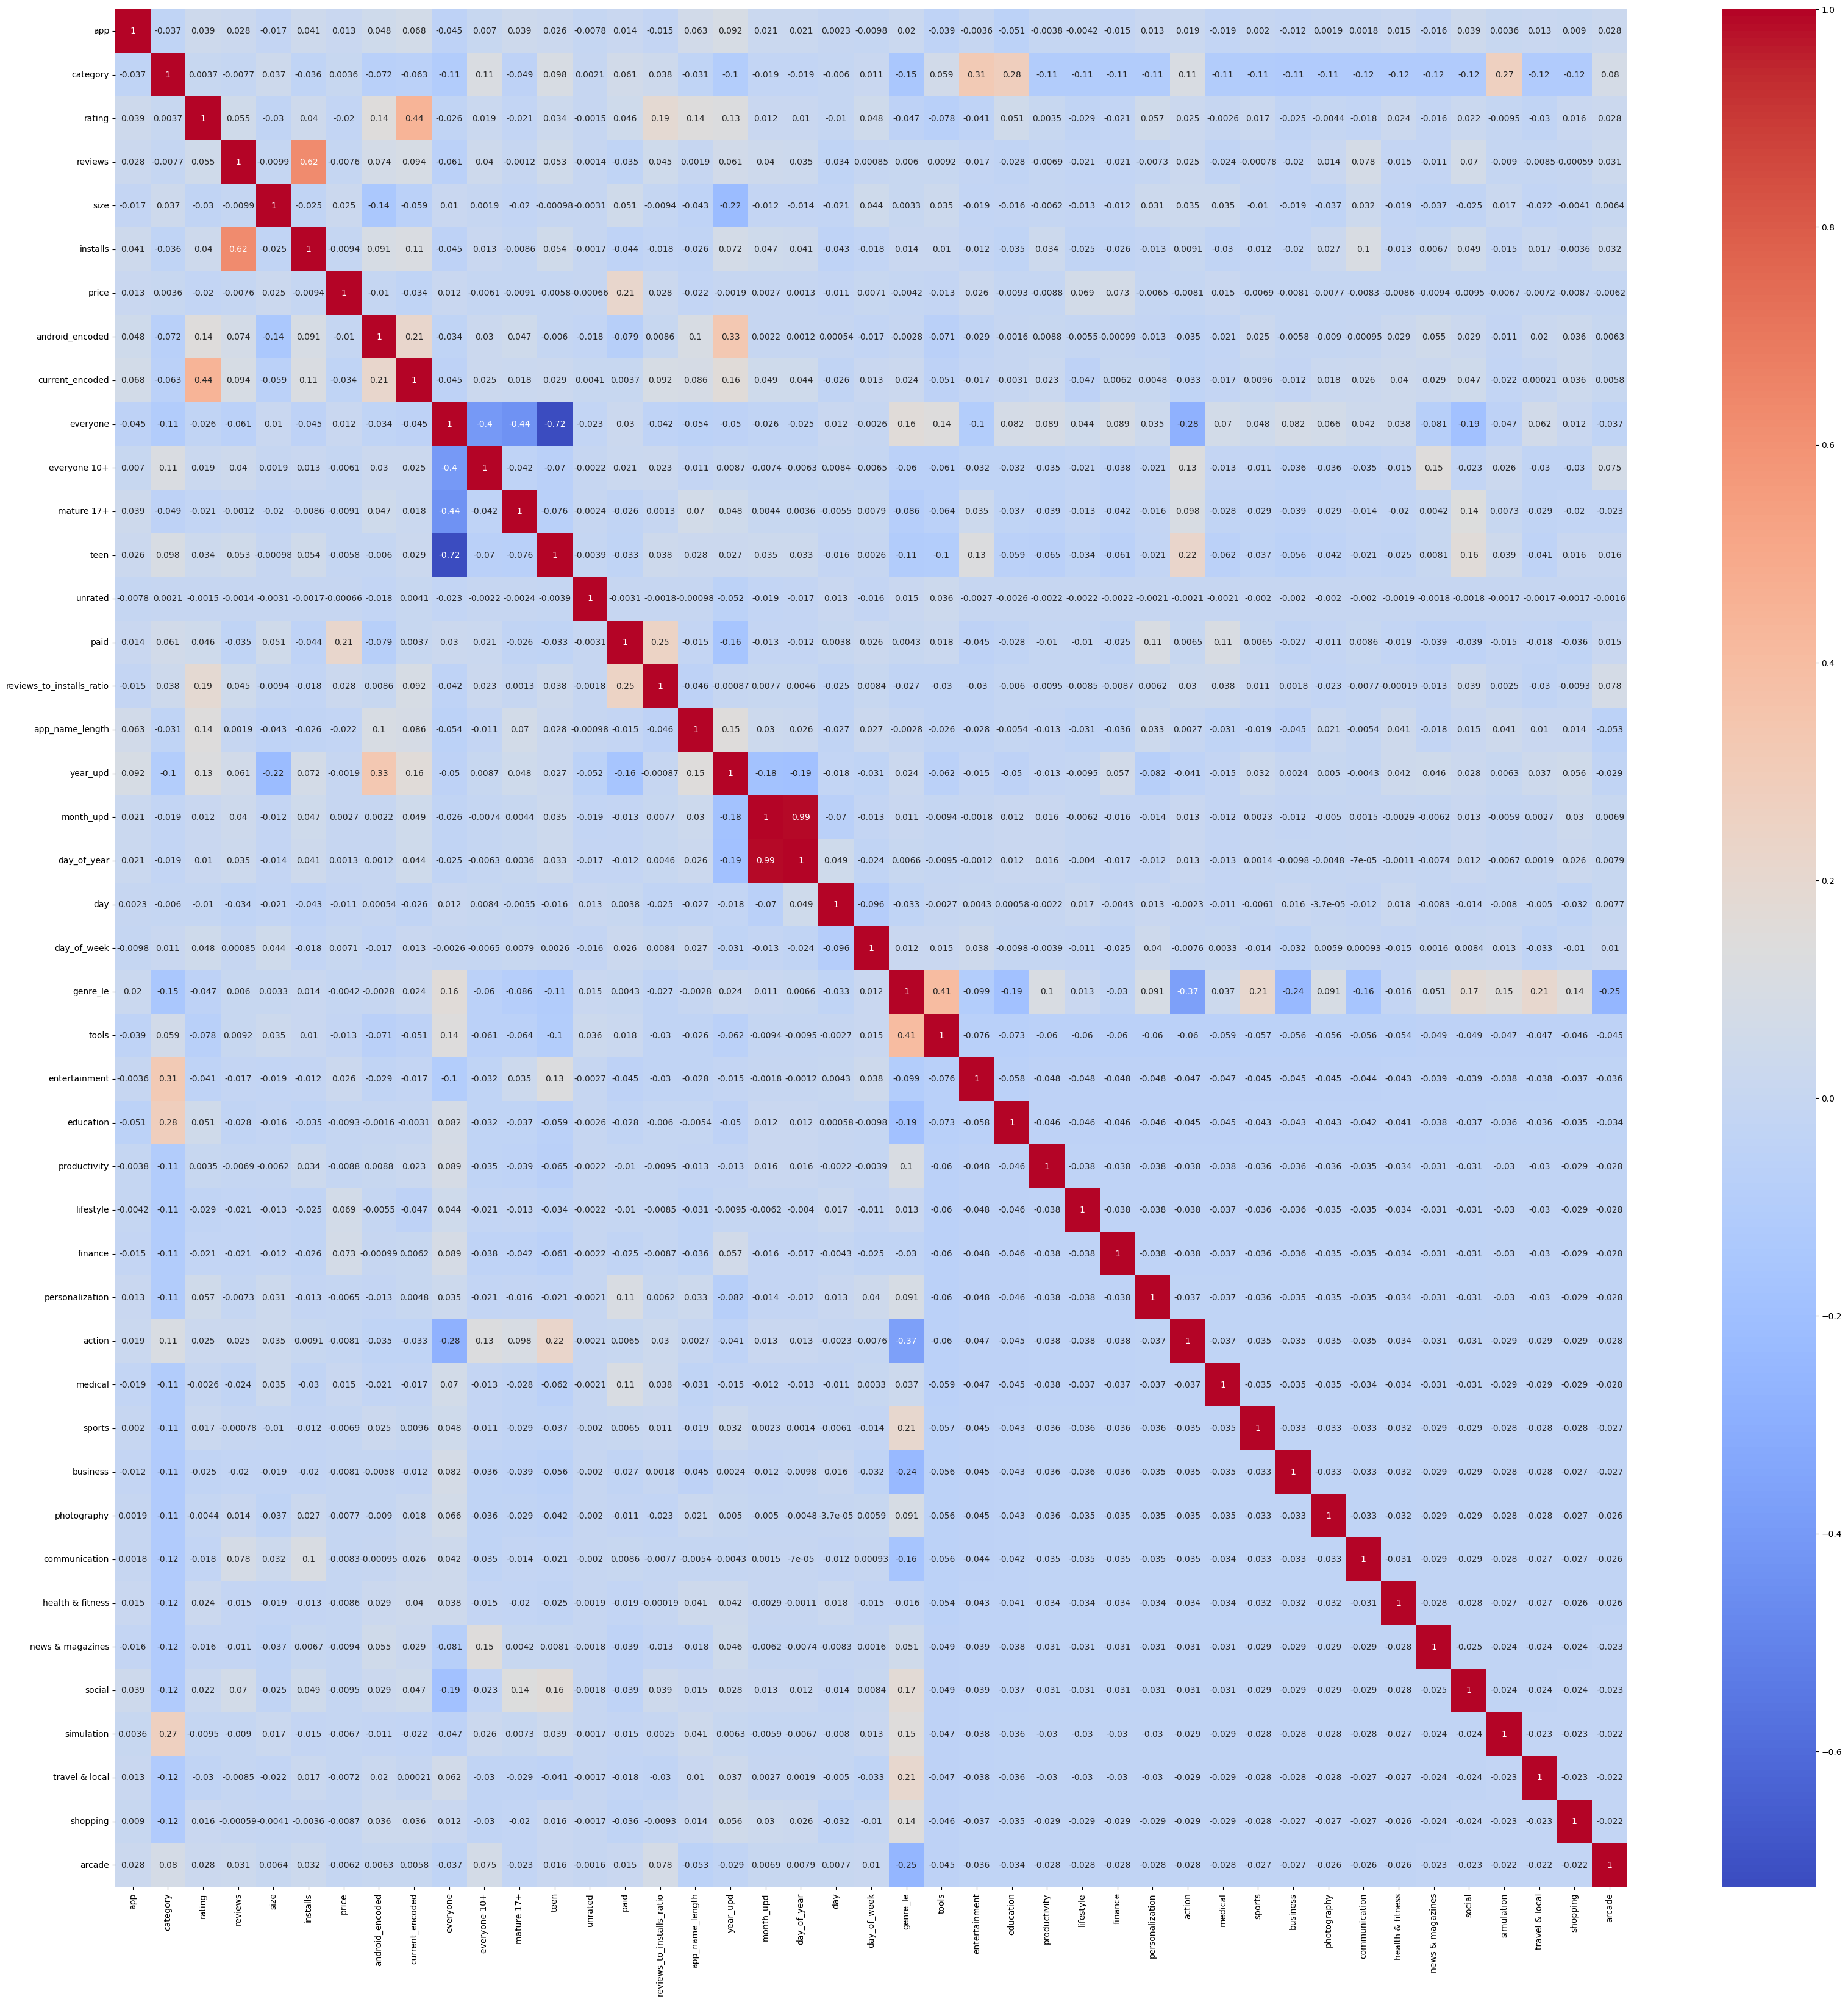

In [21]:
plt.figure(figsize = (40,40))
sns.heatmap(rating.corr(), cmap = 'coolwarm', annot = True)

#Train Test Split

In [22]:
X1 = rating_top.drop(['rating'], axis=1)
y1 = rating_top['rating']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [23]:
scale = MinMaxScaler()

X1_train_scaled = scale.fit_transform(X1_train)
X1_test_scaled = scale.transform(X1_test)

In [24]:
train_data = lgb.Dataset(X1_train_scaled, label=y1_train)
test_data = lgb.Dataset(X1_test_scaled, label=y1_test)

#**Model Training**:

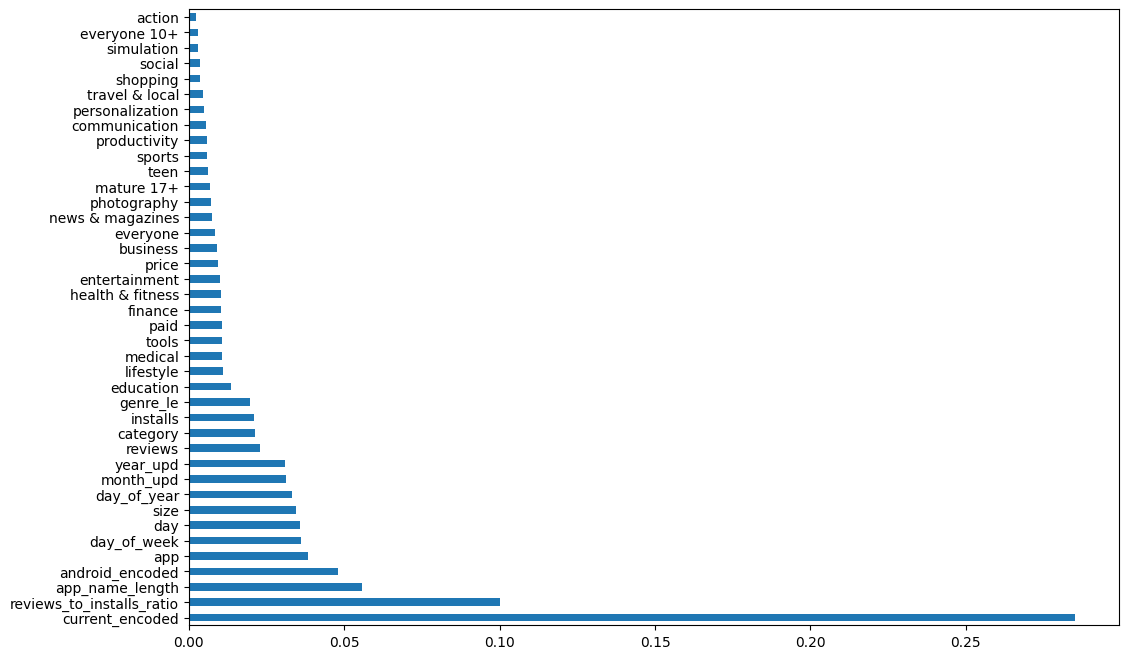

In [25]:
selection = ExtraTreesRegressor()
selection.fit(X1, y1)

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X1.columns)
feat_importances.nlargest(40).plot(kind='barh')
plt.show()

##Random Forest

In [26]:
rf_model = RandomForestRegressor(n_estimators=20,random_state=42, bootstrap = True)
rf_model.fit(X1_train_scaled, y1_train)

yrf_pred = rf_model.predict(X1_test_scaled)

rf_mse = mean_squared_error(y1_test, yrf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y1_test, yrf_pred)
rf_mae = mean_absolute_error(y1_test, yrf_pred)
print(f"rf RMSE: {rf_rmse:.2f}")
print('Mean absolute error:', rf_mae)
print("R-squared (R2) Score:", rf_r2)
print('rf MSE', rf_mse)

rf RMSE: 0.45
Mean absolute error: 0.2924831804281346
R-squared (R2) Score: 0.301433346666628
rf MSE 0.20436574923547401


##LightGBM

In [27]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,

}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
ylgb_pred = lgb_model.predict(X1_test_scaled)

lgb_mse = mean_squared_error(y1_test, ylgb_pred)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2 = r2_score(y1_test, ylgb_pred)
lgb_mae = mean_absolute_error(y1_test, ylgb_pred)
print(f"lgb RMSE: {lgb_rmse:.2f}")
print('Mean absolute error:', lgb_mae)
print("R-squared (R2) Score:", lgb_r2)
print('lgb MSE:', lgb_mse)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_col_wise=true` to remove the overhead.
lgb RMSE: 0.44
Mean absolute error: 0.2854475970159949
R-squared (R2) Score: 0.32646032653484147
lgb MSE: 0.1970441035951292


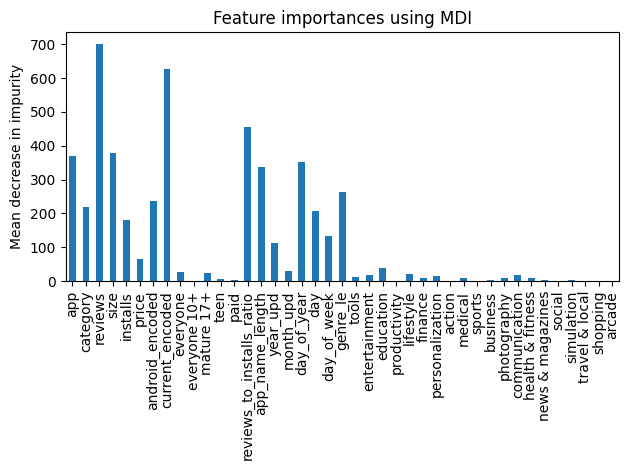

In [28]:
feature_names = X1.columns
forest_importances = pd.Series(lgb_model.feature_importance(), index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

##SVM

In [29]:
svm_model = SVR()
svm_model.fit(X1_train_scaled, y1_train)
svm_pred = svm_model.predict(X1_test_scaled)

svm_mse = mean_squared_error(y1_test, svm_pred)
svm_rmse = np.sqrt(svm_mse)
svm_mae = mean_absolute_error(y1_test, svm_pred)
svm_r2 = r2_score(y1_test, svm_pred)
print(f"svm RMSE: {svm_rmse:.2f}")
print('Mean absolute error:', svm_mae)
print("R-squared (R2) Score:", svm_r2)
print(f"SVM MSE: {svm_mse}")

svm RMSE: 0.48
Mean absolute error: 0.31983567393582424
R-squared (R2) Score: 0.2176087307004878
SVM MSE: 0.22888864961234168


##KNN

In [30]:
knn = KNeighborsRegressor(n_neighbors=5)

knn.fit(X1_train_scaled, y1_train)

yknn_pred = knn.predict(X1_test_scaled)


knn_mse = mean_squared_error(y1_test, yknn_pred)
knn_rmse = np.sqrt(knn_mse)
knn_r2 = r2_score(y1_test, yknn_pred)
knn_mae = mean_absolute_error(y1_test, yknn_pred)
print('Mean absolute error:', knn_mae)
print("Root Mean Squared Error (RMSE):", knn_rmse)
print("R-squared (R2) Score:", knn_r2)
print('knn MSE:', knn_mse)

Mean absolute error: 0.37188990825688073
Root Mean Squared Error (RMSE): 0.5360204478275961
R-squared (R2) Score: 0.017884753635262096
knn MSE: 0.28731792048929666


In [31]:
model_metrics = pd.DataFrame([
    [rf_mae, rf_mse, rf_rmse, rf_r2],
    [lgb_mae, lgb_mse, lgb_rmse, lgb_r2],
    [svm_mae, svm_mse, svm_rmse, svm_r2],
    [knn_mae, knn_mse, knn_rmse, knn_r2]
], index=['Random Forest', 'LightGBM', 'SVM', 'KNN'],
                             columns=['MAE', 'MSE', 'RMSE', 'R2'])
model_metrics

,MAE,MSE,RMSE,R2
Random Forest,0.292483,0.204366,0.452068,0.301433
LightGBM,0.285448,0.197044,0.443897,0.326460
SVM,0.319836,0.228889,0.478423,0.217609
KNN,0.371890,0.287318,0.536020,0.017885
